In [1]:
import numpy as np

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, to_hex
import matplotlib.patches as mpatches
import matplotlib.colors as mc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import axes3d, art3d, proj3d

#for dendrograms, interactive viewer window
#%matplotlib qt      
#if not using dendrograms, for inline figures
#%matplotlib inline         
#for interactive 3D plot
#%matplotlib widget

from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord, Longitude, Latitude
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy.convolution import convolve_fft, Gaussian2DKernel
from astropy.table import Table, vstack, Column, QTable
from astropy.stats import mad_std

import astrodendro
from astrodendro import dendrogram 
from astrodendro.analysis import PPVStatistic
from astrodendro.structure import Structure
from regions import RectangleSkyRegion, RectanglePixelRegion, Regions
import regions 

from spectral_cube import SpectralCube

import skimage.measure as measure
import skimage as ski

import glob
import os
import re
import imageio
import io
from math import ceil

#from open_pv import open_pv

basepath = '/home/j_poz/documents/milkywaylab/data'
drivepath = "G:/Shared drives/ACES/Paper Sprints/Inflow_EVFs"

In [2]:
tbl=Table.read(f'{basepath}/tables/HVCC_resampled_subcube_regions.ecsv')

EVF_tbl=Table.read(f'{basepath}/tables/HVCC_resampled_again.ecsv')
cube_name_list = []
for file in glob.glob(f'{basepath}/images/hi_res_cubes/EVF_*_CS21*.fits', recursive=True):
    id_num = re.search(r"(?<=EVF_)\d+", file).group()
    
    if len(id_num)==1:
        id_num=f'00{id_num}'
    elif len(id_num)==2:
        id_num=f'0{id_num}'
    else:
        None
        
    cube_name_list.append((id_num, os.path.basename(file)))

cube_name_list.sort()


vel_range_list = []
for evf in tbl:
    vel_range = (evf['min_v'], evf['max_v'])
    vel_range_list.append(vel_range)

In [3]:
mom0_list = []
mom1_list = []
cube_list = []
    
i=0
for file in cube_name_list:
    cube = SpectralCube.read(f'{basepath}/images/hi_res_cubes/{file[1]}')
    slab = cube.spectral_slab(vel_range_list[i][0]*u.km/u.s, vel_range_list[i][1]*u.km/u.s)
    mom0 = slab.moment(order=0)
    mom1 = slab.moment(order=1)

    cube_list.append(slab)
    mom0_list.append(mom0)
    mom1_list.append(mom1)
    i+=1

/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/_moments.py:182: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/home/j_poz/anaconda3/lib/python3.13/site-packages/spectral_cube/_moments.py:182: Run

In [4]:
sig_level = 3
ACES_FWHM = 3.194 #arcsec
ACES_sig = ACES_FWHM / 2.355 #arcsec
pix_scale = 0.0001*3600  #deg/pix to arcsec/pix
ACES_kern = ACES_sig/pix_scale

In [5]:
#noise_list = []
cube_noise_list = []

for i, cube in list(enumerate(cube_list)):
    #noise = mad_std(mom0[1].hdu.data, ignore_nan=True)
    #noise_list.append(noise)
        #for dendrogram min_val
    cube_noise = mad_std(cube_list[i].unmasked_data[:].value, ignore_nan=True)
    cube_noise_list.append(cube_noise)
    
#std_noise_list[65] = 0.65 #any less and contours will be around dark spots

Dendrogram masking

In [8]:
i = 29
custom_independent = astrodendro.pruning.min_peak(cube_noise_list[i])
d = astrodendro.Dendrogram.compute(cube_list[i].unmasked_data[:].value, min_value=sig_level*cube_noise_list[i], 
                                   min_npix=14, min_delta=sig_level*cube_noise_list[i], is_independent=custom_independent)
wcs = cube_list[i].wcs
mask = np.zeros(cube_list[i].unmasked_data[:].value.shape, dtype=bool)

intensities=[]
for leaf in d.leaves:
    leaf_mask = leaf.get_mask()
    mean_intensity = cube_list[i].unmasked_data[leaf_mask].mean()
    intensities.append((mean_intensity, leaf))

sorted_leaves = sorted(intensities, key=lambda x: x[0], reverse=True)
n_select = ceil(len(sorted_leaves) / 3)
top_leaves = [leaf for _, leaf in sorted_leaves[:n_select]]

pv=(0,0)
for leaf in top_leaves:
    peakl,peakb,peakv,peaki = leaf.get_peak()[0][2], leaf.get_peak()[0][1], leaf.get_peak()[0][0], leaf.get_peak()[1]
    _, peak_velocity_coords = wcs.pixel_to_world(peakl, peakb, peakv)
    if peaki > pv[1]:
        pv = (peak_velocity_coords, peaki)

for struct in top_leaves:
    mask |= struct.get_mask()

cube_masked = cube_list[i].with_mask(mask)

v1, b1, l1 = cube_list[i].world[np.ma.masked_invalid(cube_masked).mask]
l1 = Longitude(l1, unit='deg', wrap_angle=180*u.deg)
b1 = Latitude(b1, unit='deg')


SpectralCube with shape=(16, 81, 66) and unit=Jy / beam:
 n_x:     66  type_x: GLON-TAN  unit_x: deg    range:   359.815477 deg:  359.824505 deg
 n_y:     81  type_y: GLAT-TAN  unit_y: deg    range:    -0.133553 deg:   -0.122442 deg
 n_s:     16  type_s: VRAD      unit_s: km / s  range:      -26.721 km / s:      -4.453 km / s
[-26.7208776 -26.7208776 -26.7208776 ...  -4.4534796  -4.4534796
  -4.4534796] km / s


In [8]:
stvec = {}
for i, cube in (enumerate(cube_list)):
    striat = []
    d = astrodendro.Dendrogram.compute(cube.unmasked_data[:].value, min_value=sig_level*cube_noise_list[i], 
                                       min_npix=14, min_delta=sig_level*cube_noise_list[i],)
    wcs = cube_list[i].wcs
    mask = np.zeros(cube.hdu.data.shape, dtype=bool)
    
    intensities=[]
    for leaf in d.leaves:
        leaf_mask = leaf.get_mask()
        mean_intensity = cube_list[i].unmasked_data[leaf_mask].mean()
        intensities.append((mean_intensity, leaf))
    
    sorted_leaves = sorted(intensities, key=lambda x: x[0], reverse=True)
    n_select = ceil(len(sorted_leaves) / 3)
    top_leaves = [leaf for _, leaf in sorted_leaves[:n_select]]

    flux = []
    pc_size=0
    V_LSR = (0,0)
    b_min_pix = []
    b_max_pix = []
    l_min_pix = []
    l_max_pix = []
    v_min_pix = []
    v_max_pix = []
    for struct in top_leaves:
        flux=(struct.values())
        mask |= struct.get_mask()

        evf_mask = struct.get_mask()
        ind, _ = struct.get_peak()

        mask_size = []
        vel = []
    
        for v in range(np.nanmin(struct.indices()[0]), np.nanmax(struct.indices()[0])+1):
            lb_mask = evf_mask[v,:,:]
            mask_size.append(len(np.where(lb_mask == True)[0])*len(np.where(lb_mask == True)[1]))
            vel.append(v)
            
        vel_slice = vel[int(np.where(mask_size==np.nanmax(mask_size))[0][0])]
        #print(vel_slice)
        lbmax_mask = evf_mask[vel_slice,:,:]
        pc_size = np.sqrt((0.00013888888888**2)*(lbmax_mask.shape[0]*lbmax_mask.shape[1])/np.pi)*8200/180*np.pi

        peakl,peakb,peakv,peaki = struct.get_peak()[0][2], struct.get_peak()[0][1], struct.get_peak()[0][0], struct.get_peak()[1]
        _, peak_velocity_coords = wcs.pixel_to_world(peakl, peakb, peakv)
        
        if peaki >= V_LSR[1]:
            V_LSR = (peak_velocity_coords, peaki)

    if V_LSR[1]>0:
        EVF_tbl['Size'][i] = pc_size
        EVF_tbl['Median Intensity'][i] = np.round(np.median(flux), 3)
        EVF_tbl['V_LSR'][i] = V_LSR[0].value/1000
        
    cube_masked = cube.with_mask(mask)
    v1, b1, l1 = cube.world[~np.ma.masked_invalid(cube_masked).mask]
    l1 = Longitude(l1, unit='deg', wrap_angle=180*u.deg)
    b1 = Latitude(b1, unit='deg')

    if len(top_leaves) > 0:
        EVF_tbl['deltaV'][i] = abs(np.max(v1.value) - np.min(v1.value))
        EVF_tbl['min_v'][i] = np.min(v1.value)
        EVF_tbl['max_v'][i] = np.max(v1.value)
        EVF_tbl['deltal'][i] = abs(np.max(l1.value) - np.min(l1.value))
        EVF_tbl['deltab'][i] = abs(np.max(b1.value) - np.min(b1.value))
        
    striat.append(np.dstack([l1.value, b1.value, v1.value]))

    stvec[f'EVF {EVF_tbl['ID Number'][i]}'] = striat

    #cube_masked.write(f'{basepath}/inflow_EVF_masked_cubes/masked_EVF_{EVF_tbl['ID Number'][i]}.fits', overwrite=True) 

In [17]:
#EVF_tbl.write(f'{basepath}/tables/HVCC_resampled_again.ecsv', overwrite = True)

In [ ]:
v = d.viewer()
v.show()

p=d.plotter()
mom0=mom0_list[0].hdu


fig = plt.figure(figsize=(14,6))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])
ax.imshow(mom0.data, origin='lower', interpolation='nearest', cmap='gray')
p.plot_contour(ax, structure=4, color='green')
#p.plot_contour(ax,structure=2, color='yellow')

In [ ]:
mask = np.zeros(cube_list[0].hdu.data.shape, dtype=bool)

structures = d.all_structures

for struct in structures:
    mask |= struct.get_mask()

#position_masked = np.ma.masked_where(mask==False, cube_list[0].hdu.data) 

#l1,b1,v1 = np.where(~np.isnan(position_masked.data) & (position_masked.mask == False))

cube_masked = cube_list[0].with_mask(mask)

End Try Dendrogram Masking

In [149]:
def gauss_smooth(hdu_map,kern):

    smoothed = convolve_fft(hdu_map, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)
    return smoothed, kern

def get_mask(mom0, noise):
    mom0 = mom0.hdu
    mom0_wcs = WCS(mom0.header)
    
    mom0_smoothed, kern = gauss_smooth(mom0.data, ACES_kern)
    contours=measure.find_contours(mom0.data, (abs(noise)*sig_level))
    
    #fig, ax = plt.subplots(subplot_kw={'projection': mom0_wcs}, figsize = (8,8))
    #mom0_imshow = ax.imshow(mom0.data, origin='lower', cmap='gist_gray')
    #ax.contour(mom0.data, levels=[noise*sig_level], colors='lime', alpha=0.5, zorder=10)
        
    masks = []
    for z in range(len(contours)):
        mask = ski.draw.polygon2mask(mom0.data.shape, contours[z])
        mask_int = mask.astype(int)
        masks.append(mask_int)
        
    if len(contours) > 0:
        mask_tot = masks[0].copy()
        for mask in masks[1:]:
            mask_tot += mask

        mask_tot[mask_tot>0] = 1
        mask = fits.PrimaryHDU(data=mask_tot, header=mom0.header)
        
        return mask

In [ ]:
#mad_std noise
i = 65
mom0 = mom0_list[i].hdu
mom0_wcs = WCS(mom0.header)

#mom0_smoothed, kern = gauss_smooth(mom0.data, ACES_kern)
#contours=measure.find_contours(mom0.data, (abs(noise_list[0])*sig_level))

fig, ax = plt.subplots(subplot_kw={'projection': mom0_wcs}, figsize = (8,8))
mom0_imshow = ax.imshow(mom0.data, origin='lower', cmap='gist_gray')
ax.contour(mom0.data, levels=[std_noise_list[i]*sig_level], colors='lime', alpha=0.5, zorder=10)

#masks = []
#for z in range(len(contours)):
    #mask = ski.draw.polygon2mask(mom0.data.shape, contours[z])
    #mask_int = mask.astype(int)
    #masks.append(mask_int)
plt.show()

In [ ]:
mask_list = []

i=0
for mom0 in mom0_list:
    mask = get_mask(mom0=mom0, noise=std_noise_list[i])
    i+=1
    mask_list.append(mask)

min_list=[]
max_list=[]
int_list=[]

for mom0 in list(enumerate(mom0_list)):
    if mask_list[mom0[0]]:
        mask_data = mask_list[mom0[0]].data
    else:
        continue
    
    mom0_data = mom0_list[mom0[0]].hdu.data
    position_masked = np.ma.masked_where(mask_data==0, mom0_data)
    
    min_list.append(np.nanmin(position_masked.data))
    max_list.append(np.nanmax(position_masked.data))
    int_list.append(position_masked.data)
    
mom0_norm=Normalize(vmin=min(min_list), vmax=max(max_list))

In [253]:
stvec1 = {}

for i in range(len(mom0_list)):
    striat_cat = []

    mom0_hdu = mom0_list[i].hdu      
    mom0_data = mom0_hdu.data
    mom0_wcs = WCS(mom0_hdu.header)

    
    mom1_hdu = mom1_list[i].hdu
    mom1_data = mom1_hdu.data
    mom1_wcs = WCS(mom1_hdu.header)

    if mask_list[i]: #some cubes are too small, no contours are found
        mask_hdu = mask_list[i]       
        mask_data = mask_hdu.data
        mask_wcs = WCS(mask_hdu.header)
    else:
        continue
        
    position_masked = np.ma.masked_where(mask_data==0, mom0_data) 
    l1,b1 = np.where(~np.isnan(position_masked.data) & (position_masked.mask == False))
    l_sky = pixel_to_skycoord(l1,b1,mom0_wcs).l 
    l_sky.wrap_angle = 180 * u.deg
    b_sky = pixel_to_skycoord(l1,b1,mom0_wcs).b
    intensity = mom0_norm(position_masked.data[np.where(~np.isnan(position_masked.data) & (position_masked.mask == False))])
    
    v1 = np.zeros(l1.shape) #make array for mom1 velocity centroid
    for j in range(len(b1)):
        v1[j] = mom1_data[l1[j]][b1[j]] # populate v1 array


    striat_cat.append(np.dstack([l_sky.deg,b_sky.deg,v1, intensity]))

    #pattern = r"_l([-+]?\d*\.?\d+)_b([-+]?\d*\.?\d+)\.fits"
    #match = re.search(pattern, mom0_file_list[i])
    #l = float(match.group(1))
    #b = float(match.group(2))

    stvec1[f'EVF {i}'] = striat_cat

In [21]:
verticality = []
for i, evf in list(enumerate(stvec)):
    if stvec[evf][0][0].any():
        lmin = stvec[evf][0][:,:,0][0].min()
        lmax = stvec[evf][0][:,:,0][0].max()
        lrange = abs(abs(lmax) - abs(lmin))

    

        vmin = stvec[evf][0][:,:,2][0].min()
        vmax = stvec[evf][0][:,:,2][0].max()
        vdisp = abs((vmax) - (vmin))
            
        verticality.append(vdisp/lrange)
        EVF_tbl['Verticality'][i] = round((vdisp/lrange), 3)

    else:
        EVF_tbl['Verticality'][i]=np.nan
        #stvec.pop(evf)
        continue

    #print(i, vmax, vmin, vdisp, lrange, vdisp/lrange)
data = np.array(verticality)
norm = LogNorm(vmin=data.min(), vmax=data.max())
normalized_data = norm(data)
rgba_colors = mpl.cm.magma(normalized_data)

In [23]:

lmin = stvec['EVF 234'][0][:,:,0][0].min()
lmax = stvec['EVF 234'][0][:,:,0][0].max()
lrange = abs(abs(lmax) - abs(lmin))



vmin = stvec['EVF 234'][0][:,:,2][0].min()
vmax = stvec['EVF 234'][0][:,:,2][0].max()
vdisp = abs((vmax) - (vmin))

In [26]:
EVF_tbl.write(f'{basepath}/tables/HVCC_resampled_again.ecsv', overwrite=True)

In [18]:
scouse_fits = pd.read_csv('C:/Users/kubek/Downloads/MilkyWayLab/Data/Tables/final_cmz_scouse_hnco_fits.csv',
              usecols=[0,1,2,3,5,7], names=['n', 'l', 'b', 'amp', 'velocity', 'FWHM'],
              sep="\s+")

l = scouse_fits['l'].values
b = scouse_fits['b'].values
v = scouse_fits['velocity'].values
amp = scouse_fits['amp'].values

kdl = np.loadtxt("C:/Users/kubek/Downloads/MilkyWayLab/Data/Tables/kdl_lbv.txt", unpack=True)
klk, kbk, kvk = kdl[0], kdl[1], kdl[2]

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kubek\AppData\Local\Temp\ipykernel_5352\763810444.py:3: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+")


In [11]:
tile5= (1,0.602)
tile4= (0.66,0.25)
tile3= (0.293,0.007)
tile2= (0.007, -0.307)
tile1= (-0.307,-1)

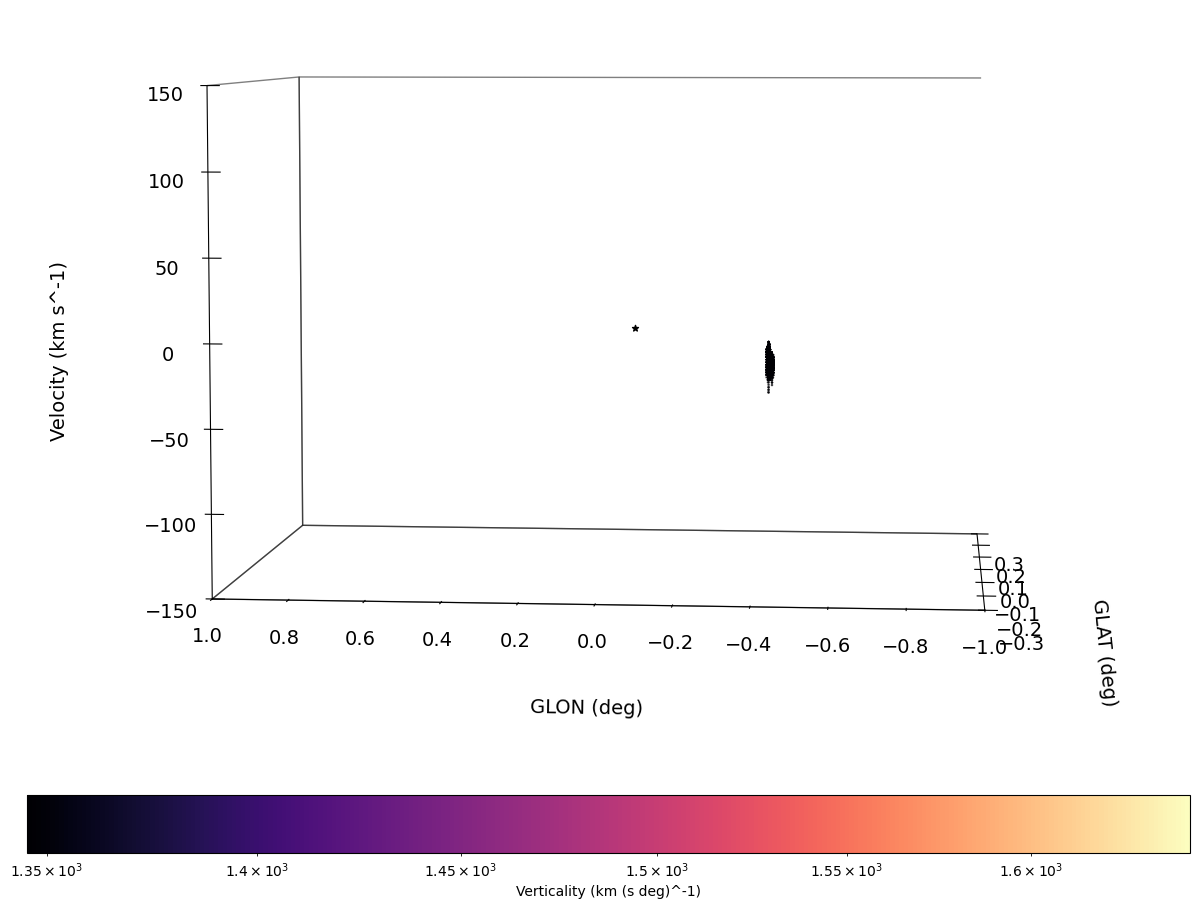

In [46]:
#############################
# PLOT
#############################

norm = LogNorm(vmin=min(verticality), vmax=max(verticality))

fig = plt.figure(figsize=(15,12), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
ax.set_box_aspect(aspect=(1.5, 1, 1), zoom=1.5)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

#ax.plot(klk[2:16] , kbk[2:16] , kvk[2:16] ,ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
#ax.plot(klk[15:26], kbk[15:26], kvk[15:26],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
#ax.plot(klk[25:36], kbk[25:36], kvk[25:36],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
#ax.plot(klk[35:51], kbk[35:51], kvk[35:51],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)

#ax.scatter(l, b, v, c=amp, cmap='Grays', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1, zorder=10)


for reg in enumerate(list(stvec.keys())):
    for k in stvec[reg[1]]:
        l1, b1, v1 = k[:,:,0][0], k[:,:,1][0],k[:,:,2][0]
        ax.scatter(l1, b1, v1, color=rgba_colors[reg[0]], marker='o', s=0.5, alpha=0.1, zorder=1)
        
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='bottom')
cbar.set_label('Verticality (km (s deg)^-1)')

# Set the azimuth and elevation angles
ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_xticks(ticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlim(1,-1)
ax.set_ylim(-0.3,0.3)
ax.set_zlim(-150.,150.)
ax.set_xlabel('GLON (deg)', labelpad=20, fontsize=14)
ax.set_ylabel('GLAT (deg)', labelpad=20, fontsize=14)
ax.set_zlabel('Velocity (km s^-1)', labelpad=20, fontsize=14, rotation=90)
ax.zaxis.set_rotate_label(False)

plt.show()

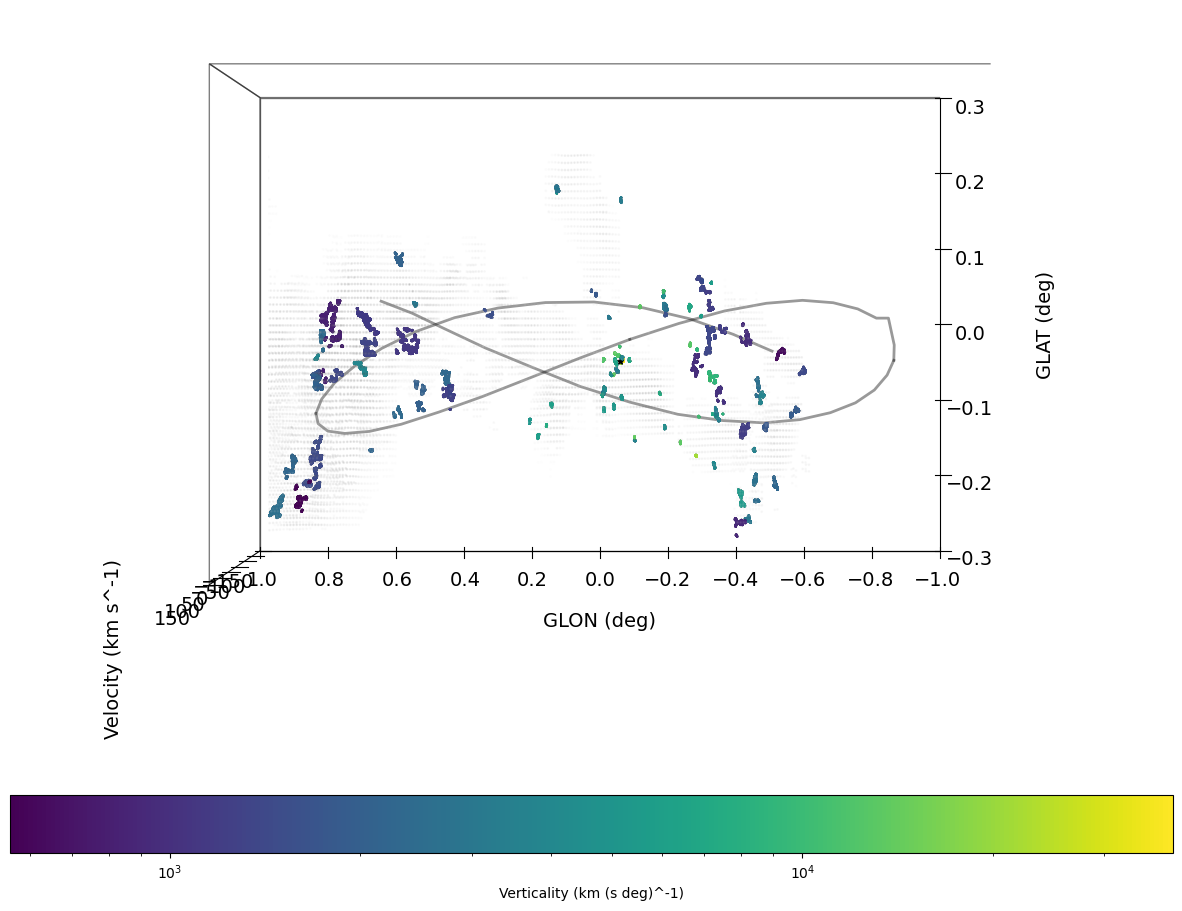

In [343]:
#Copy
#############################
# PLOT
#############################

norm = LogNorm(vmin=min(verticality), vmax=max(verticality))

fig = plt.figure(figsize=(15,12), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
ax.set_box_aspect(aspect=(1.5, 1, 1), zoom=1.5)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(klk[2:16] , kbk[2:16] , kvk[2:16] ,ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[15:26], kbk[15:26], kvk[15:26],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[25:36], kbk[25:36], kvk[25:36],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[35:51], kbk[35:51], kvk[35:51],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)

ax.scatter(l, b, v, c=amp, cmap='Grays', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1, zorder=10)


for reg in enumerate(list(stvec.keys())):
    for k in stvec[reg[1]]:
        l1, b1, v1 = k[:,:,0][0], k[:,:,1][0],k[:,:,2][0]
        ax.scatter(l1, b1, v1, color=rgba_colors[reg[0]], marker='o', s=0.5, alpha=0.1, zorder=1)
        
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='bottom')
cbar.set_label('Verticality (km (s deg)^-1)')

# Set the azimuth and elevation angles
ax.view_init(azim=-90, elev=90)
ax.dist = 13

ax.set_xticks(ticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlim(1,-1)
ax.set_ylim(-0.3,0.3)
ax.set_zlim(-150.,150.)
ax.set_xlabel('GLON (deg)', labelpad=20, fontsize=14)
ax.set_ylabel('GLAT (deg)', labelpad=20, fontsize=14)
ax.set_zlabel('Velocity (km s^-1)', labelpad=20, fontsize=14, rotation=90)
ax.zaxis.set_rotate_label(False)

plt.show()

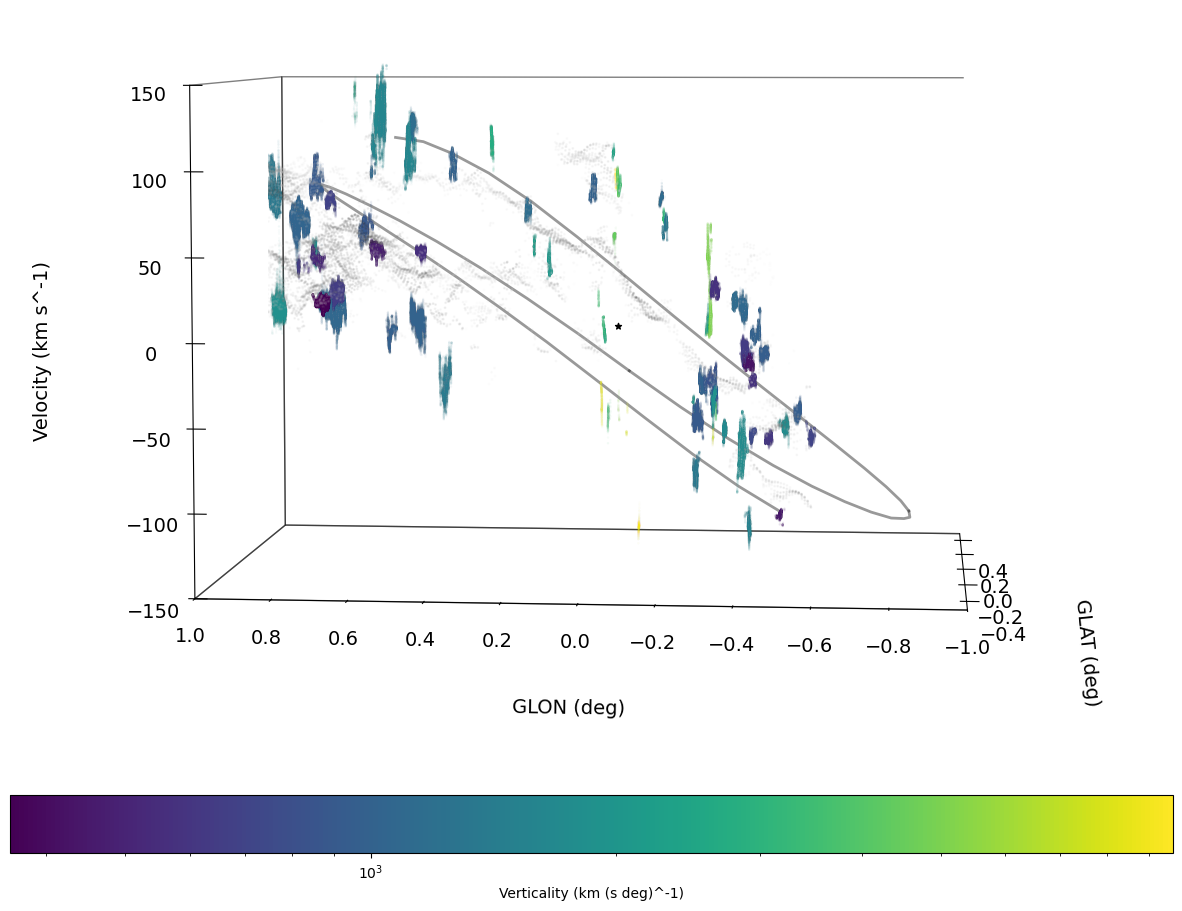

In [150]:
#Copy with intensity weighted alpha/opacity
#############################
# PLOT
#############################

fig = plt.figure(figsize=(15,12), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
ax.set_box_aspect(aspect=(1.5, 1, 1), zoom=1.5)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(klk[2:16] , kbk[2:16] , kvk[2:16] ,ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[15:26], kbk[15:26], kvk[15:26],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[25:36], kbk[25:36], kvk[25:36],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[35:51], kbk[35:51], kvk[35:51],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)

ax.scatter(l, b, v, c=amp, cmap='Grays', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1, zorder=10)

for reg in enumerate(list(stvec.keys())):
    for k in stvec[reg[1]]:
        l1, b1, v1, intensity = k[:,:,0][0], k[:,:,1][0],k[:,:,2][0],k[:,:,3][0]
        ax.scatter(l1, b1, v1, color=rgba_colors[reg[0]], marker='o', s=0.5, facecolor='1', alpha=0.3*intensity, zorder=1)

norm = LogNorm(vmin=min(verticality), vmax=max(verticality))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='bottom')
cbar.set_label('Verticality (km (s deg)^-1)')

# Set the azimuth and elevation angles
ax.view_init(azim=-85, elev=5)
ax.dist = 13

ax.set_xticks(ticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlim(1,-1)
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-150.,150.)
ax.set_xlabel('GLON (deg)', labelpad=20, fontsize=14)
ax.set_ylabel('GLAT (deg)', labelpad=20, fontsize=14)
ax.set_zlabel('Velocity (km s^-1)', labelpad=20, fontsize=14, rotation=90)
ax.zaxis.set_rotate_label(False)

plt.show()

In [219]:
def offset(data, placed_labels, scale=0.05, threshold=0.1):
    origin = data
    offset = np.zeros(3)
    
    def repel_label(others):
        nonlocal offset
        
        for point in others:
            dist = np.linalg.norm(origin - point)
            
            if dist > threshold:
                direction = origin - point
                
                if np.all(direction == 0):
                    direction = abs(np.random.randn(3))
                    
                direction /= np.linalg.norm(direction)
                strength = (threshold - dist) / threshold
                offset += direction * strength

    repel_label(data)
    repel_label(np.array(placed_labels))

    if np.linalg.norm(offset) > 0:
        offset = scale * offset / np.linalg.norm(offset)
    return origin + offset


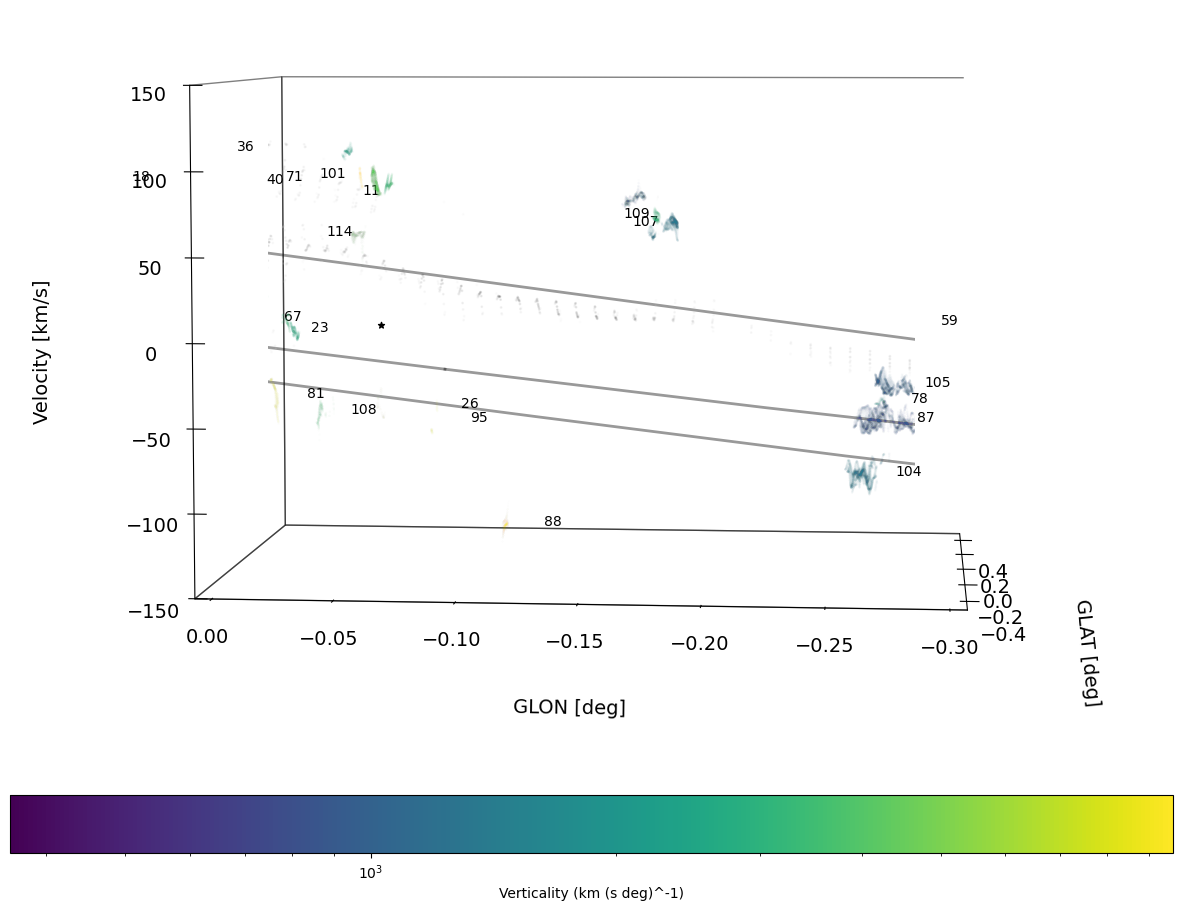

In [240]:
#############################
# Zoom in PLOT
tile = tile5
#############################

fig = plt.figure(figsize=(15,12), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
ax.set_box_aspect(aspect=(1.5, 1, 1), zoom=1.5)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
ax.zaxis._axinfo['juggled'] = (1,2,0) #Change Spine Position

ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(klk[2:16] , kbk[2:16] , kvk[2:16] ,ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[15:26], kbk[15:26], kvk[15:26],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[25:36], kbk[25:36], kvk[25:36],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[35:51], kbk[35:51], kvk[35:51],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)

ax.scatter(l, b, v, c=amp, cmap='Grays', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1, zorder=10)


placed_labels = np.empty((0,3))
#plot EVFS
for reg in enumerate(list(stvec.keys())): 
    points = []
    #add points to scatter
    for k in stvec[reg[1]]:
        l1, b1, v1, intensity = k[:,:,0][0], k[:,:,1][0],k[:,:,2][0],k[:,:,3][0]
        ax.scatter(l1, b1, v1, color=rgba_colors[reg[0]], marker='o', s=0.5, facecolor='1', alpha=0.1*intensity, zorder=1)
        points.append((l1, b1, v1))

        
    #check if EVF is within tile range
    points_in_tile = np.sum((points[0][0] <= tile[0]) & (points[0][0] >= tile[1]))
    if points_in_tile < len(points[0][0]):
        continue

    #place labels    
    l_cent, b_cent, v_cent = np.mean(points[0][0]), np.mean(points[0][1]), np.mean(points[0][2])
    x,y,z = offset(data=np.array([l_cent, b_cent, v_cent]), placed_labels=placed_labels, threshold=0.4, scale=0.3)
    placed_labels=np.vstack([placed_labels, [x, y, z]])
    ax.text(x,y,z,reg[1].split()[1])

#Add colorbar
norm = LogNorm(vmin=min(verticality), vmax=max(verticality))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='bottom')
cbar.set_label('Verticality (km (s deg)^-1)')

# Set the azimuth and elevation angles
ax.view_init(azim=-85, elev=5)
ax.dist = 13

#ax.set_xticks(ticks = [-1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlim(tile[0],tile[1])
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-150.,150.)
ax.set_xlabel('GLON [deg]', labelpad=20, fontsize=14)
ax.set_ylabel('GLAT [deg]', labelpad=20, fontsize=14)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Velocity [km/s]', labelpad=20, rotation=90, fontsize=14)

plt.show()

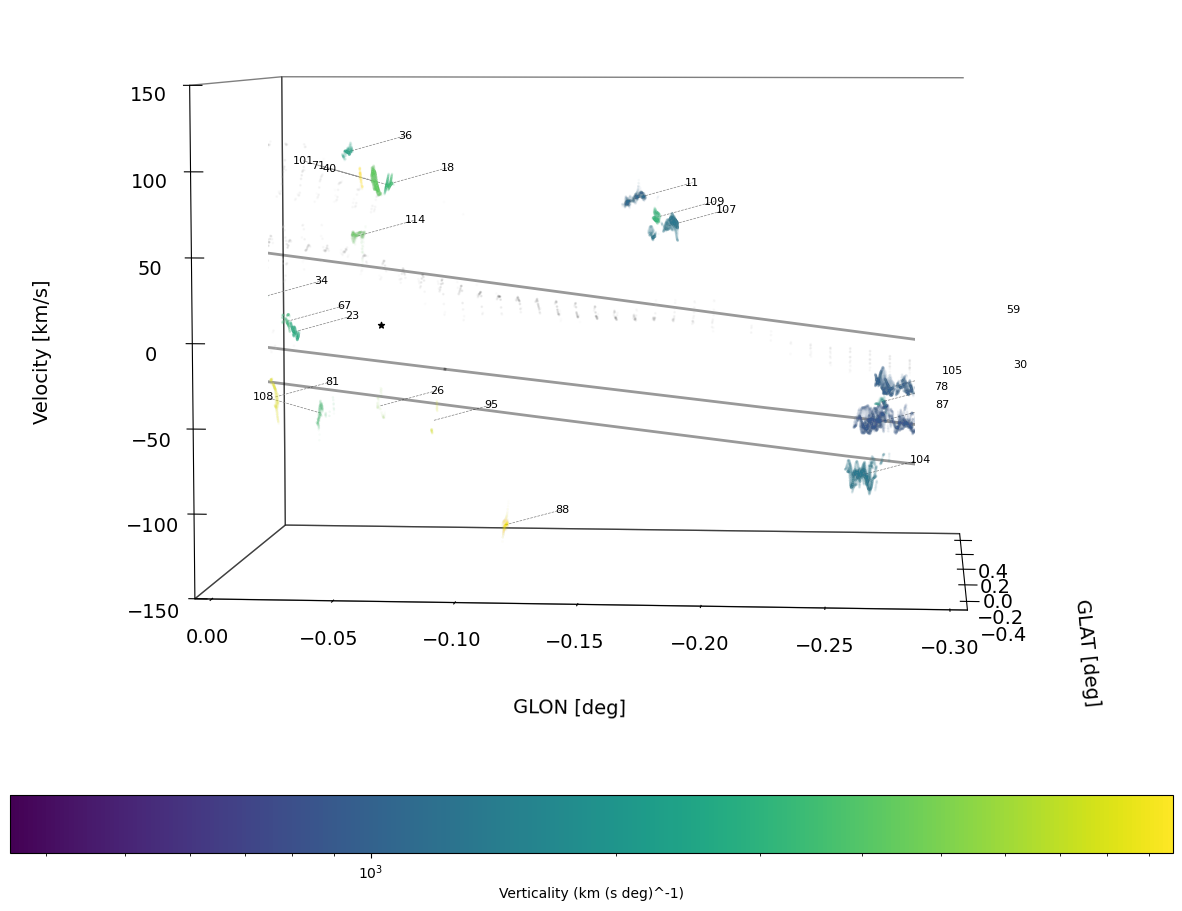

In [218]:
norm = LogNorm(vmin=min(verticality), vmax=max(verticality))
#############################
# Zoom in PLOT
tile = tile2
#############################

fig = plt.figure(figsize=(15,12), dpi=100)
ax = fig.add_subplot(111, projection='3d', rasterized=True)
ax.set_box_aspect(aspect=(1.5, 1, 1), zoom=1.5)


fig.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False) # Hide grid lines
#change spine position
ax.zaxis._axinfo['juggled'] = (1,2,0)

ax.scatter(-0.056, -0.046, 0, marker = "*", s=20, color='k') #plot SgrA*

ax.plot(klk[2:16] , kbk[2:16] , kvk[2:16] ,ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[15:26], kbk[15:26], kvk[15:26],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[25:36], kbk[25:36], kvk[25:36],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)
ax.plot(klk[35:51], kbk[35:51], kvk[35:51],ls='-', color='k', linewidth=2, zorder=2, alpha=0.4)

ax.scatter(l, b, v, c=amp, cmap='Grays', marker='o', s=1, facecolor='1', norm=mpl.colors.LogNorm(), alpha=0.1, zorder=10)

projected_label_coords = []
for reg in enumerate(list(stvec.keys())):          #plot EVFs
    points = []
    for k in stvec[reg[1]]:
        l1, b1, v1, intensity = k[:,:,0][0], k[:,:,1][0],k[:,:,2][0],k[:,:,3][0]
        ax.scatter(l1, b1, v1, color=rgba_colors[reg[0]], marker='o', s=0.5, facecolor='1', alpha=0.3*intensity, zorder=1)
        points.append((l1, b1, v1))

    points_in_tile = np.sum((points[0][0] <= tile[0]) & (points[0][0] >= tile[1]))       #check if EVF and label in within plot limits
    if points_in_tile < len(points[0][0]) / 2:
        continue
        
    l_cent, b_cent, v_cent = np.mean(points[0][0]), np.mean(points[0][1]), np.mean(points[0][2])
    l2, v2, _ = proj3d.proj_transform(l_cent+0.025, v_cent+10, b_cent, ax.get_proj())
    display = ax.figure.canvas.get_renderer()
    bbox_center = ax.transData.transform((l2, v2))
    
    too_close = False
    for px, py in projected_label_coords:
        if np.hypot(px - bbox_center[0], py - bbox_center[1]) < 15:
            too_close = True
            break
            
    if not too_close:
        ax.text(l_cent-0.025, b_cent, v_cent+10, reg[1].split()[1], fontsize=8, ha='center', va='center', zorder=2)
        ax.plot([l_cent, l_cent-0.025], [b_cent, b_cent], [v_cent, v_cent+10], color='gray', linestyle='--', linewidth=0.5, zorder=1)
        projected_label_coords.append(bbox_center)
        continue

    ax.text(l_cent+0.025, b_cent, v_cent+10, reg[1].split()[1], fontsize=8, ha='center', va='center', zorder=2)
    ax.plot([l_cent, l_cent+0.025], [b_cent, b_cent], [v_cent, v_cent+10], color='gray', linestyle='--', linewidth=0.5, zorder=1)
    projected_label_coords.append(bbox_center)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, location='bottom')
cbar.set_label('Verticality (km (s deg)^-1)')

# Set the azimuth and elevation angles
ax.view_init(azim=-85, elev=5)
ax.dist = 13

#ax.set_xticks(ticks = [-1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlim(tile[0],tile[1])
ax.set_ylim(-0.5,0.5)
ax.set_zlim(-150.,150.)
ax.set_xlabel('GLON [deg]', labelpad=20, fontsize=14)
ax.set_ylabel('GLAT [deg]', labelpad=20, fontsize=14)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Velocity [km/s]', labelpad=20, rotation=90, fontsize=14)

plt.show()

In [ ]:
frames = []
azimuths = np.linspace(0, 135, 50) 
norm = LogNorm(vmin=min(verticality2), vmax=max(verticality2))

for azim in azimuths:
    fig = plt.figure(figsize=(15, 12), dpi=100)
    ax = fig.add_subplot(111, projection='3d', rasterized=True)

    fig.set_facecolor('white')
    ax.set_facecolor('white')
    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.zaxis._axinfo['juggled'] = (1, 2, 0)

    ax.scatter(-0.056, -0.046, 0, marker="*", s=20, color='k')

    ax.plot(klk[2:16], kbk[2:16], kvk[2:16], ls='-', color='k', linewidth=2, alpha=0.4)
    ax.plot(klk[15:26], kbk[15:26], kvk[15:26], ls='-', color='k', linewidth=2, alpha=0.4)
    ax.plot(klk[25:36], kbk[25:36], kvk[25:36], ls='-', color='k', linewidth=2, alpha=0.4)
    ax.plot(klk[35:51], kbk[35:51], kvk[35:51], ls='-', color='k', linewidth=2, alpha=0.4)

    ax.scatter(l, b, v, c=amp, cmap='Greys', marker='o', s=1, norm=mpl.colors.LogNorm(), alpha=0.1)

    for reg in enumerate(list(stvec.keys())):
        for k in stvec[reg[1]]:
            l1, b1, v1, intensity = k[:, :, 0][0], k[:, :, 1][0], k[:, :, 2][0], k[:,:,3][0]
            ax.scatter(l1, b1, v1, color=rgba_colors[reg[0]], marker='o', s=0.5, facecolor='1', alpha=0.3*intensity, zorder=1)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, location='bottom')
    cbar.set_label('Verticality (km (s deg)^-1)')

    ax.view_init(elev=5, azim=azim)
    ax.dist = 13

    ax.set_xticks(ticks=np.linspace(-1.0, 1.2, 12))
    ax.set_xlim(1.2, -1.2)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(-150., 150.)
    ax.set_xlabel('GLON [deg]', labelpad=20, fontsize=12)
    ax.set_ylabel('GLAT [deg]', labelpad=20, fontsize=12)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Velocity [km/s]', labelpad=20, rotation=90, fontsize=12)

    # Save to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frames.append(imageio.v3.imread(buf))
    plt.close(fig)
    print(azim)

In [ ]:
imageio.mimwrite(f'{basepath}/inflow_evf_PPV_w_cmap.gif', frames, duration=2, loop=0)

In [101]:
EVF_tbl['Size'] = EVF_tbl['deltal']*np.pi/180*8200*EVF_tbl['deltab']*np.pi/180*8200

In [271]:
#EVF_tbl['ID Number', 'l', 'b','V_LSR', 'deltaV', 'Size', 'Median Intensity', 'Verticality', 'Spectrum FWHM', 'Classification Comments'].write(f'{drivepath}/DATA/Identification/TILES_TABLES/inflow_HVCCs_paper_table.csv', overwrite=True)

In [16]:
EVF_tbl['Size'].dtype

dtype('float64')

In [17]:
for i, col in enumerate(EVF_tbl.colnames):
    if EVF_tbl[col].dtype == 'float64':
        EVF_tbl[col] = np.round(EVF_tbl[col], 3)

In [3]:
EVF_tbl.write(f'{basepath}/tables/HVCC_resampled_again.tex', format="latex", overwrite=False)

In [5]:
EVF_tbl[[29,64,83]]

ID Number,l,b,deltal,deltab,V_LSR,deltaV,Verticality,Size,Median Intensity,Spectrum FWHM,min_v,max_v,Classification Comments,dendro_match
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str55,float64
29,-0.18,-0.128,0.0027776898497222646,0.002083312651599195,-5.9379728,1.4844932000000002,534.434,0.8199705685075968,0.078,nan,-5.9379728,-4.4534796,--,6585.0
64,-0.059,0.153,0.002638856578130344,0.0033333013063805705,11.8759456,1.484493200000001,562.552,0.8034695441535025,0.266,nan,11.8759456,13.3604388,--,nan
83,-0.107,-0.012,0.0013888623880120576,0.001249988543124558,-133.60438799999997,1.4844932000000028,1068.855,0.7401635988029885,0.104,nan,-133.60438799999997,-132.11989479999997,--,nan
